In [2]:
import os
import numpy as np
import pandas as pd
from unidecode import unidecode

# pip install -q unidecode

In [3]:
import openai
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())
openai.api_key = os.environ.get("OPENAI_API_KEY")

In [4]:
file_path = []
for root, dirs, files in os.walk("data/"):
    file_path.extend(files)
    break

file_path = [file for file in file_path if "all" not in file]

df = []
for file in file_path:
    df.append(pd.read_csv(root + file))

df_all = pd.concat(df, ignore_index=True)
df_all.head()

,jobTitle,company,location,salary,date posted,link,description,qualifications,date pulled
0,Data Scientist,Zenith,"New York, NY","$70,000 - $105,000 a year",NaN,https://www.simplyhired.com/job/P_p1hn27u3cTsW...,Company Description\n\nZenith is the ROI Agenc...,Power BI||Microsoft Excel||Management||SAS||Re...,NaN
1,Senior Data Scientist,"Charlie Health Engineering, Product & Design","New York, NY","$148,500 - $228,000 a year",NaN,https://www.simplyhired.com/job/ikx9-0RLxNfIx5...,Why Charlie Health?\nYoung people across the c...,TensorFlow||Growing experience||Management||Py...,NaN
2,Machine Learning Engineer,FalconSmartIT,"New York, NY",Estimated: $144K - $183K a year,NaN,https://www.simplyhired.com/job/OvfIVz13IToF5W...,Job Title: Machine Learning Engineer\nLocation...,TensorFlow||Oracle||Kubernetes||RESTful API||P...,NaN
3,Data Scientist,Morgan Stanley,"New York, NY",Estimated: $150K - $190K a year,NaN,https://www.simplyhired.com/job/zdQBTgDHV97jOa...,Data Scientist\nJob Number:\n3245996\nPOSTING ...,Ontology||TensorFlow||Oracle||Statistics||Doct...,NaN
4,Data Scientist,City of Jersey City,"Jersey City, NJ","$60,000 - $67,000 a year",NaN,https://www.simplyhired.com/job/QW6PGA25yHL-mA...,Job Opening:\nData Scientist - Innovation\nDep...,ArcGIS||Microsoft Word||Microsoft Excel||Micro...,NaN


In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   jobTitle        159 non-null    object 
 1   company         159 non-null    object 
 2   location        159 non-null    object 
 3   salary          146 non-null    object 
 4   date posted     0 non-null      float64
 5   link            159 non-null    object 
 6   description     159 non-null    object 
 7   qualifications  159 non-null    object 
 8   date pulled     97 non-null     object 
dtypes: float64(1), object(8)
memory usage: 11.3+ KB


In [6]:
df_all.drop_duplicates(subset = ['description']  ,inplace=True)
df_all.shape

(128, 9)

In [7]:
df_all['description'].apply(unidecode)

0      Company Description\n\nZenith is the ROI Agenc...
1      Why Charlie Health?\nYoung people across the c...
2      Job Title: Machine Learning Engineer\nLocation...
3      Data Scientist\nJob Number:\n3245996\nPOSTING ...
4      Job Opening:\nData Scientist - Innovation\nDep...
                             ...                        
151    Software Engineer - Data Quality\nat Second Sp...
153    Optum is a global organization that delivers c...
154    JOB DESCRIPTION\n\nJob Description:\nOur Asset...
155    Company Description\n\nEtsy is the global mark...
158    Practice - AIA - Artificial Intelligence and A...
Name: description, Length: 128, dtype: object

In [8]:
# Clean description
## Pre-processing the text before using it with the text-embedding-ada-002 model can indeed be beneficial, but isn’t necessary.
## remove non-ascii characters
df_all['description'] = df_all['description'].apply(unidecode)


# Get Salary min and max

df_all['salary'] = df_all['salary'].str.replace(r'[^\d,-]', '', regex=True)
df_all['salary'] = df_all['salary'].str.replace(',', '')
df_all['salary'].fillna('-1', inplace=True)
salary = df_all['salary'].str.split('-', expand=True)

## convert to int and add to df_all
salary.columns = ['min_salary', 'max_salary']
salary['max_salary'].fillna(salary['min_salary'], inplace=True)
salary['min_salary'] = salary['min_salary'].apply(lambda x: x if len(x) > 3 else x + '000')
salary['max_salary'] = salary['max_salary'].apply(lambda x: x if len(x) > 3 else x + '000')

df_all.drop('salary', axis=1, inplace=True)
df_all = pd.concat([df_all, salary.astype('int32')], axis=1)

df_all.reset_index(inplace=True, drop=True)

In [9]:
df_all.to_csv('data/df_all.csv', index=False)

## Get Embedings

In [10]:
from openai import embeddings
from typing import Union, List

embeddingModel = 'text-embedding-3-small'

def get_embedding(text: str)->List[float]:
    text = text.replace("\n", " ")
    embedding = embeddings.create(
        input=text,
        model=embeddingModel
    )
    return embedding.data[0].embedding

In [11]:
df_all['embedding'] = df_all['description'].apply(get_embedding)

In [12]:
df_all.head()

,jobTitle,company,location,date posted,link,description,qualifications,date pulled,min_salary,max_salary,embedding
0,Data Scientist,Zenith,"New York, NY",NaN,https://www.simplyhired.com/job/P_p1hn27u3cTsW...,Company Description\n\nZenith is the ROI Agenc...,Power BI||Microsoft Excel||Management||SAS||Re...,NaN,70000,105000,"[-0.0014290509279817343, 0.055856604129076004,..."
1,Senior Data Scientist,"Charlie Health Engineering, Product & Design","New York, NY",NaN,https://www.simplyhired.com/job/ikx9-0RLxNfIx5...,Why Charlie Health?\nYoung people across the c...,TensorFlow||Growing experience||Management||Py...,NaN,148500,228000,"[-0.0016314274398609996, 0.002888173097744584,..."
2,Machine Learning Engineer,FalconSmartIT,"New York, NY",NaN,https://www.simplyhired.com/job/OvfIVz13IToF5W...,Job Title: Machine Learning Engineer\nLocation...,TensorFlow||Oracle||Kubernetes||RESTful API||P...,NaN,144000,183000,"[-0.02468576468527317, -0.02219345234334469, 0..."
3,Data Scientist,Morgan Stanley,"New York, NY",NaN,https://www.simplyhired.com/job/zdQBTgDHV97jOa...,Data Scientist\nJob Number:\n3245996\nPOSTING ...,Ontology||TensorFlow||Oracle||Statistics||Doct...,NaN,150000,190000,"[-0.015597617253661156, 0.015471013262867928, ..."
4,Data Scientist,City of Jersey City,"Jersey City, NJ",NaN,https://www.simplyhired.com/job/QW6PGA25yHL-mA...,Job Opening:\nData Scientist - Innovation\nDep...,ArcGIS||Microsoft Word||Microsoft Excel||Micro...,NaN,60000,67000,"[-0.015759838744997978, 0.013187067583203316, ..."


In [13]:
df_all.to_csv('data/df_all.csv', index=False)

<Axes: xlabel='jobTitle'>

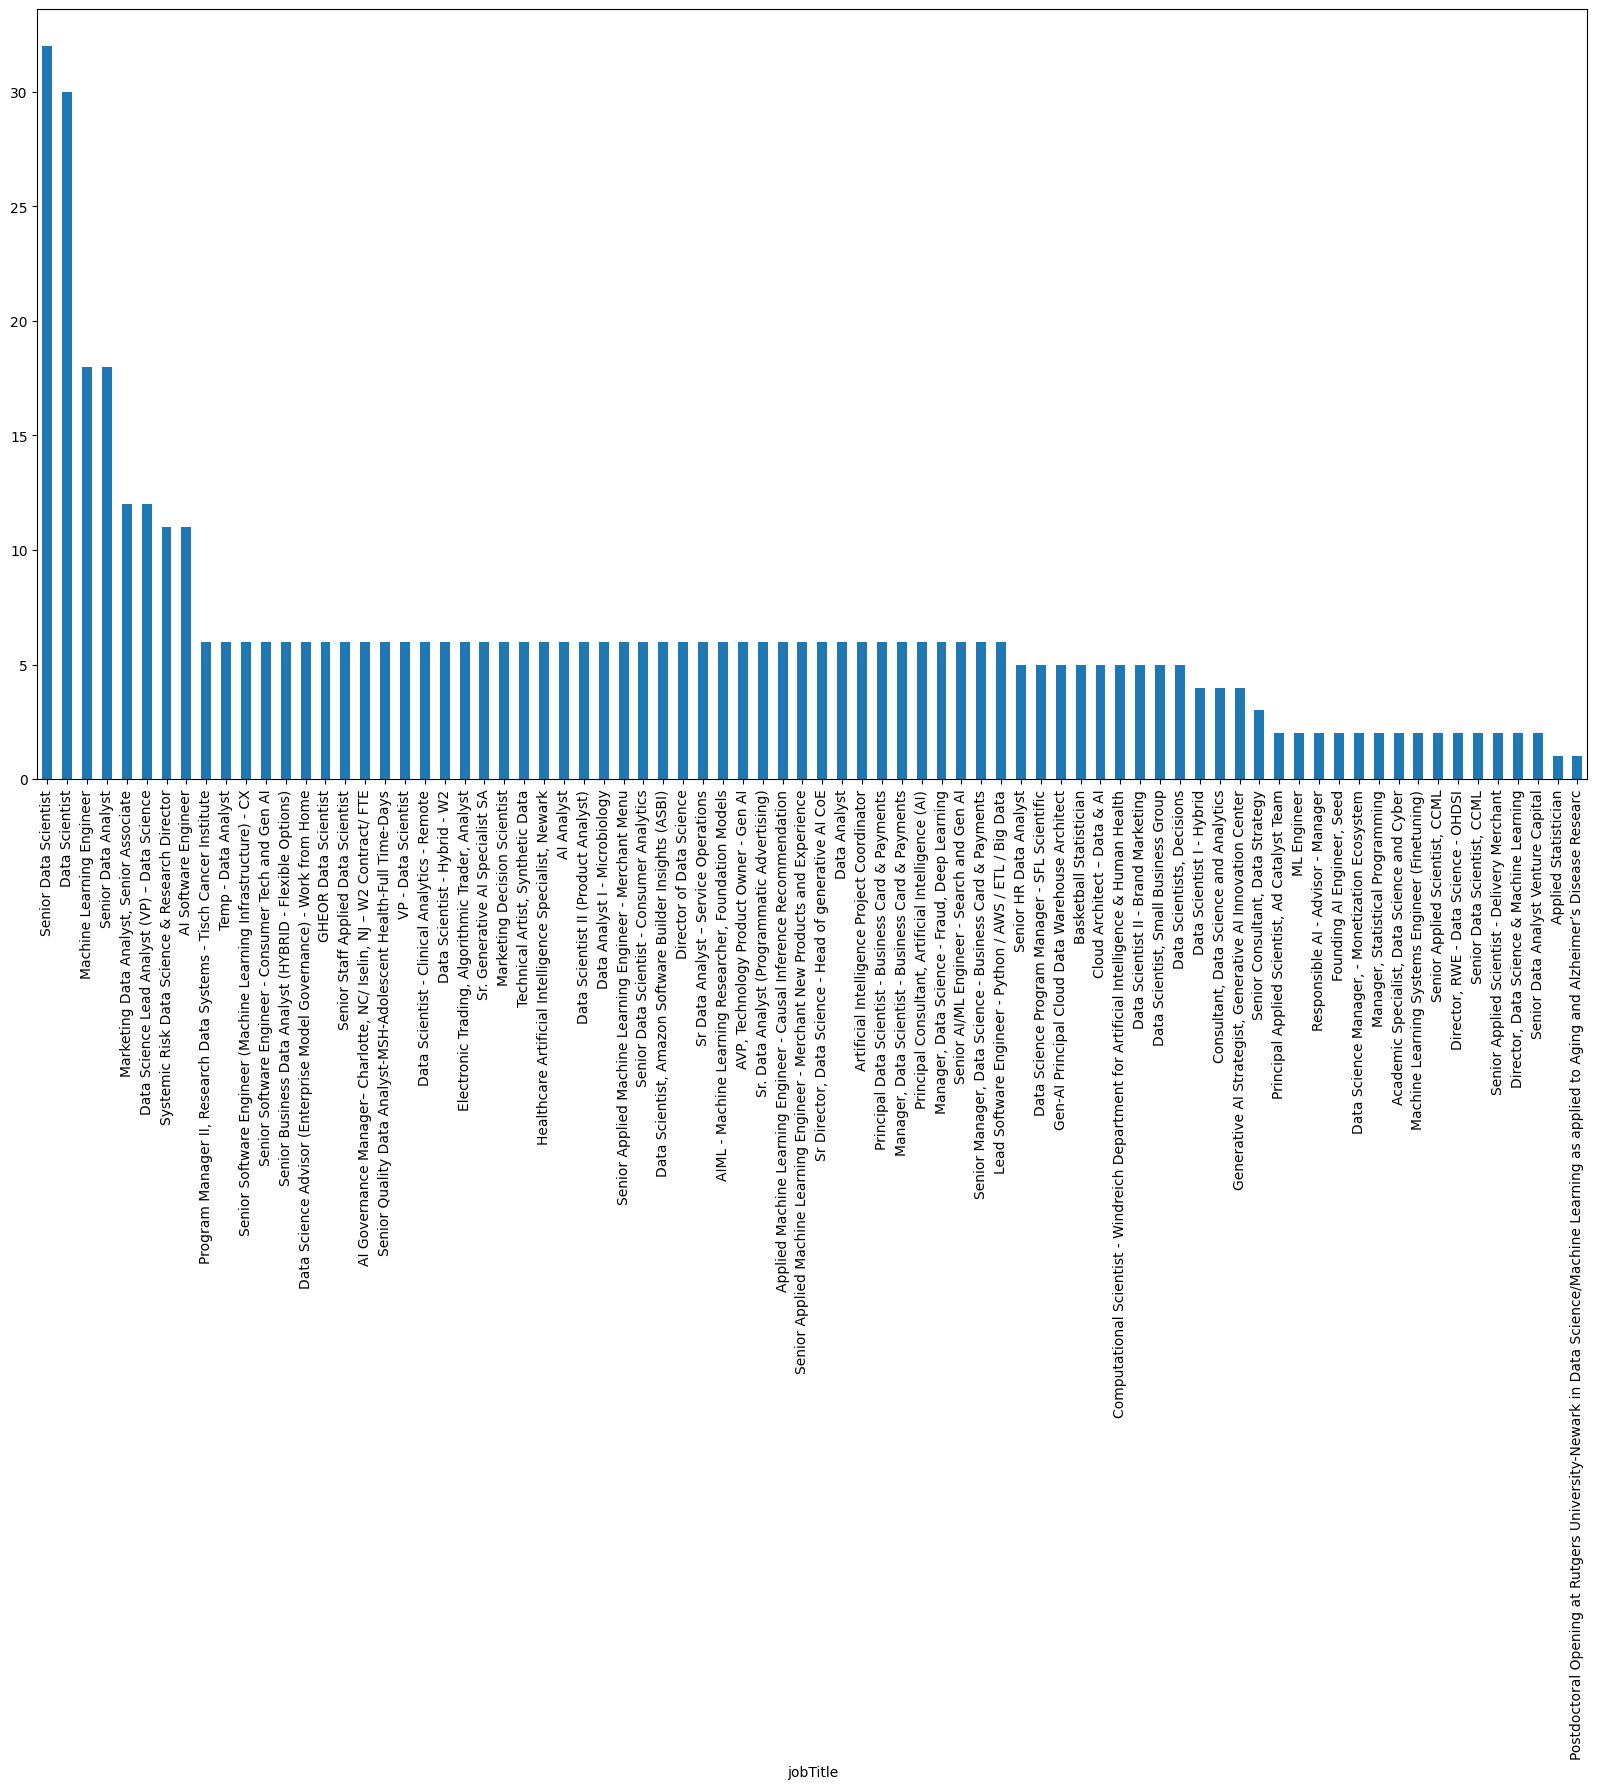

In [103]:
df_all['jobTitle'].value_counts().plot(kind='bar', figsize=(20, 10))

In [104]:
import os
from dotenv import load_dotenv, find_dotenv

import openai

_ = load_dotenv(find_dotenv())
openai.api_key = os.environ.get("OPENAI_API_KEY")

llm_model = "gpt-3.5-turbo-0301"

In [105]:
template = """
Examples:

job_title: Senior Data Scientist
Data Scientist

job_title: Data Science
Data Scientist

job_title: Data Science Manager
Data Scientist

job_title: Data Scientist
Data Scientist

job_title:Senior Data Analyst
Data Analyst

job_title: Machine Learning Engineer
Machine Learning Engineer

job_title: Applied Statistician
Statistician

job_title: Computational Scientist - Windreich Department for Artificial Intelligence & Human Health
Computational Scientist

job_title: Cloud Architect – Data & AI
Cloud Architect

job_title: ML Engineer
Machine Learning Engineer

job_title: Artificial Intelligence (AI) Consultant  
Artificial Intelligence 


###
job_title : {job_title}
###

Using the above examples, given the job_title between ### and ###, return job_family only


"""#.format(job_title="Data Scientist")

In [106]:
def get_result(prompt, model = "gpt-3.5-turbo-1106", temperature=0):
    messages = [{'role': 'user', 'content': prompt}]
    response =  openai.chat.completions.create(
        model = model,
        messages = messages,
        temperature = temperature
    )
    return response.choices[0].message.content

In [107]:
df_all['job_family']  = df_all['jobTitle'].apply(lambda x: get_result(template.format(job_title=x),model = llm_model, temperature=0))




In [108]:
df_all['job_family'] = df_all['job_family'].str.split(':').str[-1]
df_all['job_family'] = df_all['job_family'].str.strip()

<Axes: xlabel='job_family'>

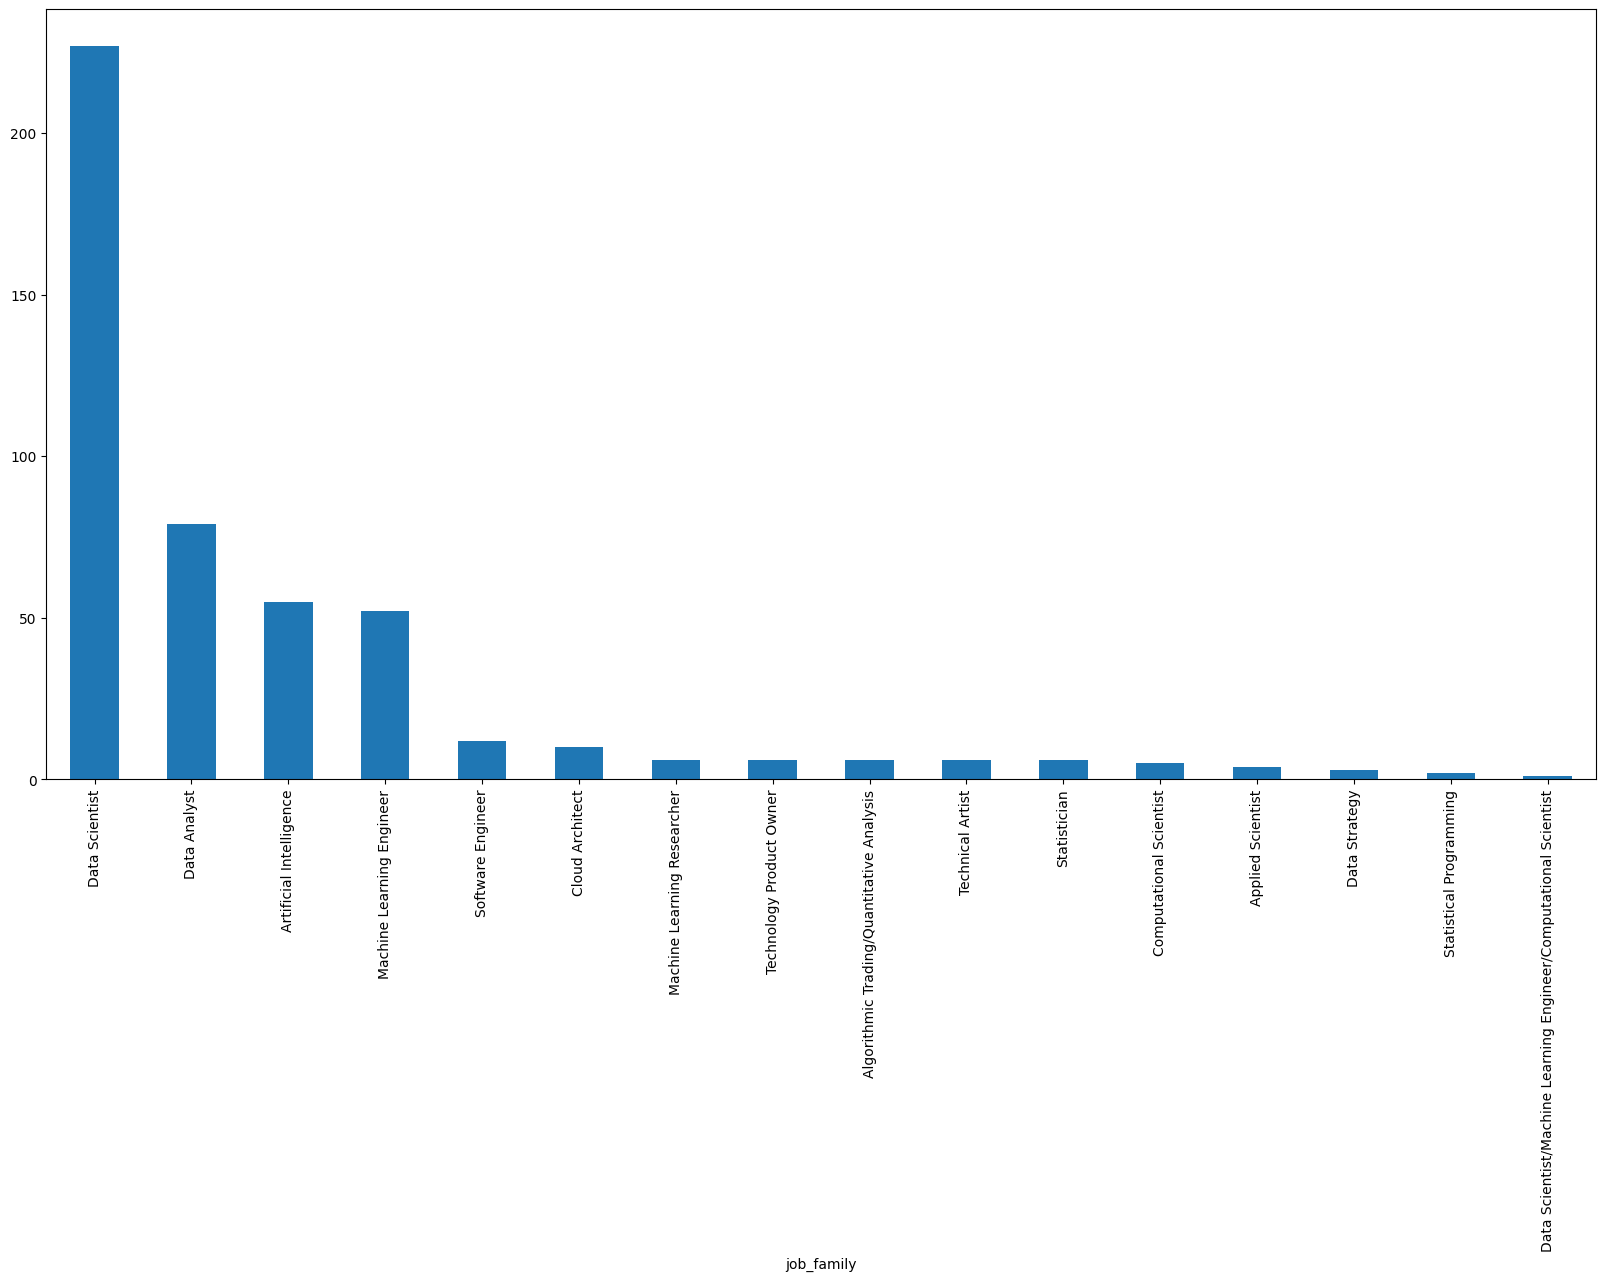

In [109]:
df_all['job_family'].value_counts().plot(kind='bar', figsize=(20, 10))

In [110]:
df_all['job_family'].value_counts()

job_family
Data Scientist                                                      227
Data Analyst                                                         79
Artificial Intelligence                                              55
Machine Learning Engineer                                            52
Software Engineer                                                    12
Cloud Architect                                                      10
Machine Learning Researcher                                           6
Technology Product Owner                                              6
Algorithmic Trading/Quantitative Analysis                             6
Technical Artist                                                      6
Statistician                                                          6
Computational Scientist                                               5
Applied Scientist                                                     4
Data Strategy                                        

In [111]:
df_all.to_csv('data/df_all.csv', index=False)